In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from keras.datasets import cifar10
import tensorflow as tf
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


2024-11-21 11:11:06.399362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CIFAR-10 Image Dataset:

Downloaded from https://www.cs.toronto.edu/~kriz/cifar.html

In [4]:
# Load the CIFAR-10 dataset
(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar10.load_data()
#cifar_x_train[0, :, :, 0].shape
print('Images in CIFAR10 Training and Testing sets:')
print(cifar_x_train.shape, cifar_y_train.shape, cifar_x_test.shape, cifar_y_test.shape)

Images in CIFAR10 Training and Testing sets:
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## MINST Image Dataset: 

In [5]:
mnist = tf.keras.datasets.mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
#mnist_x_train[0].shape
print('Images in MNIST Training and Testing sets:')
print(mnist_x_train.shape, mnist_y_train.shape, mnist_x_test.shape, mnist_y_test.shape)

Images in MNIST Training and Testing sets:
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


## Load Functions

In [6]:
def load_image_as_matrix(image_path):
    image = img_as_float(io.imread(image_path, as_gray=True))  # Convert image to grayscale
    return image

def add_gaussian_noise(image, mean, std):
    #np.random.seed(10)
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 255), noise

def apply_svd(image_matrix):
    U, S, Vt = np.linalg.svd(image_matrix, full_matrices=False)
    return U, S, Vt

def truncate_svd(U, S, Vt, k):
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    return U_k, S_k, Vt_k

def reconstruct_image(U_k, S_k, Vt_k):
    new_image = np.dot(U_k, np.dot(S_k, Vt_k))
    return new_image

def evaluate_compression(original_image, compressed_image, k):
    m , n = original_image.shape
    cr = (m * n) / (m * k + k + k * n)
    psnr_resut = psnr(original_image, compressed_image)
    mse_result = mse(original_image, compressed_image)
    ssim_result, dif = ssim(original_image, compressed_image, full=True, data_range=compressed_image.max()-compressed_image.min())
    return cr, psnr_resut, mse_result, ssim_result

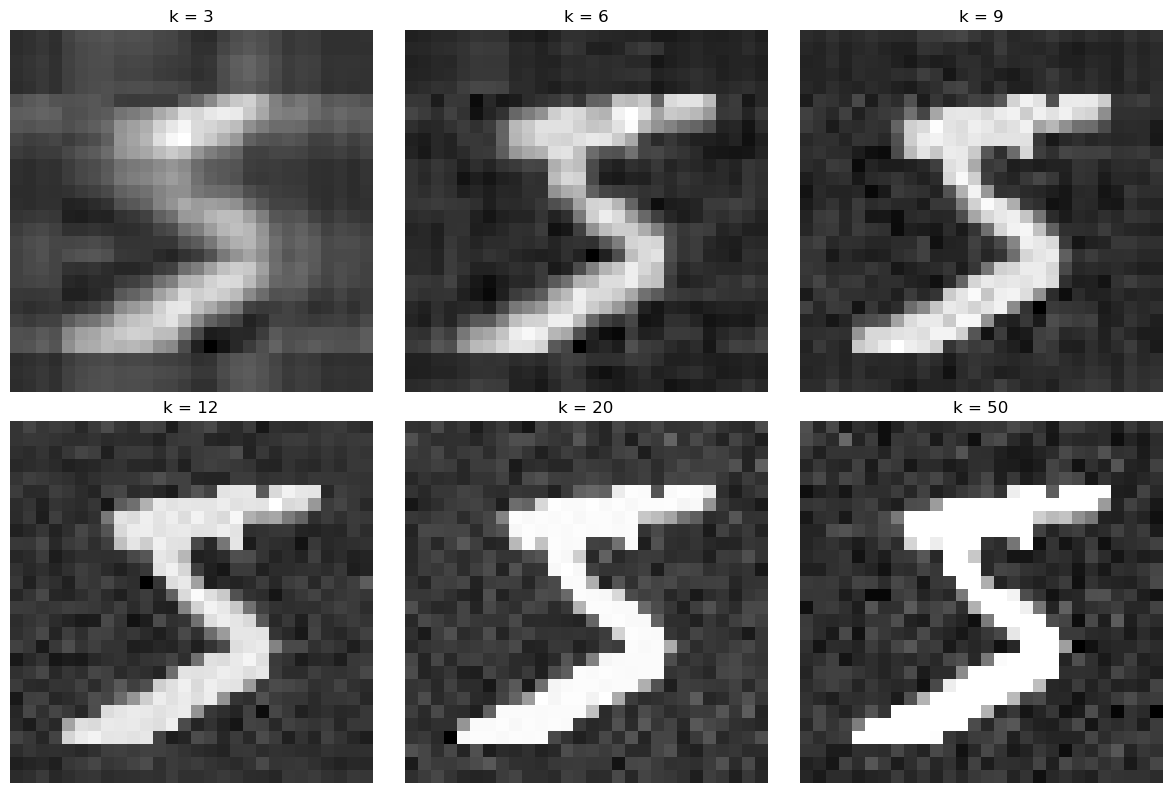

In [88]:
plt.figure(figsize=(12, 8))  # Set the figure size

for i, k in enumerate([3, 6, 9, 12, 20, 50]):
    original_image = mnist_x_train[0]
    noisy_image, noise = add_gaussian_noise(original_image, 128, 10)
    U, S, Vt = apply_svd(noisy_image)
    U_k, S_k, Vt_k = truncate_svd(U, S, Vt, k)
    reconstructed_image = reconstruct_image(U_k, S_k, Vt_k)
    plt.subplot(2, 3, i+1)  # Create a 2x3 grid of subplots
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'k = {k}')
    plt.axis('off')  # Hide axes
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [36]:
def plot_images(dataset, k, mean, sd):
    #print(' K = ', k)
    fig, axes = plt.subplots(5, 5, figsize=(10, 4))

    for i in range(5):
        if(dataset == 'cifar'):
            original_image = cifar_x_test[i, :, :, 0]
        if(dataset == 'mnist'):
            original_image = mnist_x_test[i]
        noisy_image, noise = add_gaussian_noise(original_image, mean, sd)
        U, S, Vt = apply_svd(noisy_image)
        U_k, S_k, Vt_k = truncate_svd(U, S, Vt, k)
        reconstructed_image = reconstruct_image(U_k, S_k, Vt_k)
        compression_ratio, quality, mse, ssim = evaluate_compression(original_image, reconstructed_image, k)
        #print(mse)
        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].plot(noise, color='grey')
        axes[1, i].set_title("Gaussian Noise")
        axes[1, i].axis('off')
        #plt.show()
        axes[2, i].imshow(noisy_image, cmap='gray')
        axes[2, i].set_title("Noisy")
        axes[2, i].axis('off')
        axes[3, i].imshow(reconstructed_image, cmap='gray')
        axes[3, i].set_title("Reconstructed")
        axes[3, i].axis('off')
        axes[4, i].set_title("MSE = " + str(round(mse, 3)))
        axes[4, i].axis('off')
        plt.axis('off')  # Hide axes
        plt.figtext(0.5, 0.01, 'K = ' + str(k))
    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()

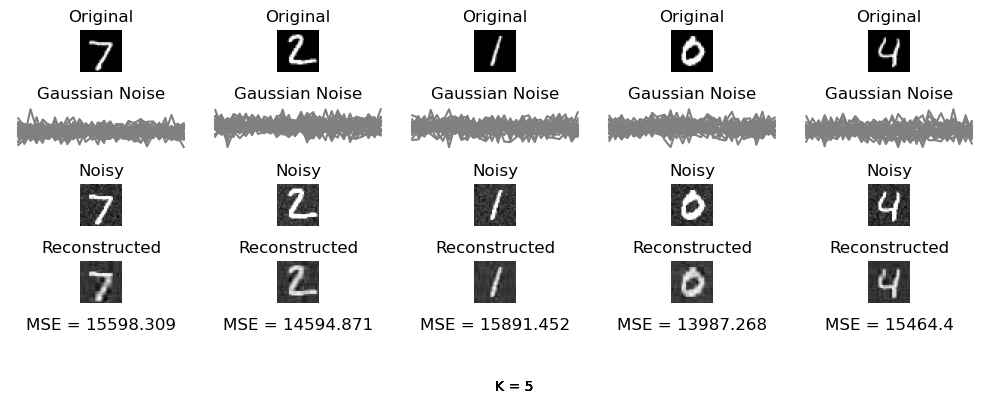

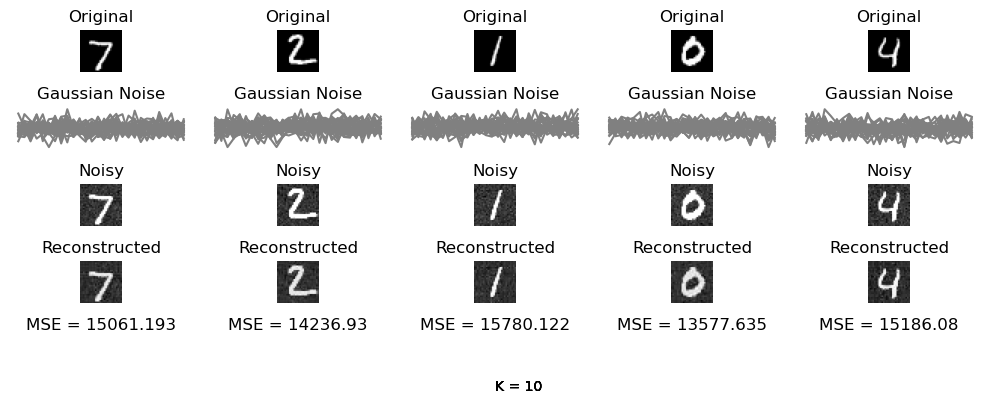

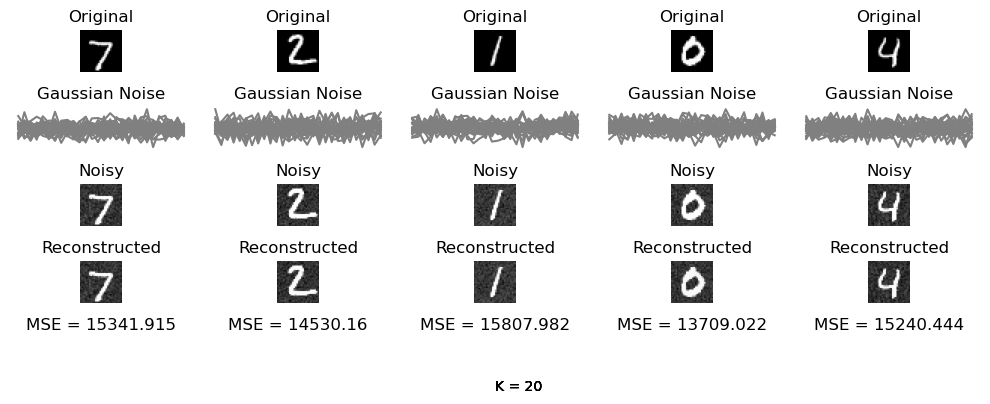

In [37]:
plot_images("mnist", k = 5, mean = 128, sd = 10)
plot_images("mnist", k = 10, mean = 128, sd = 10)
plot_images("mnist", k = 20, mean = 128, sd = 10)


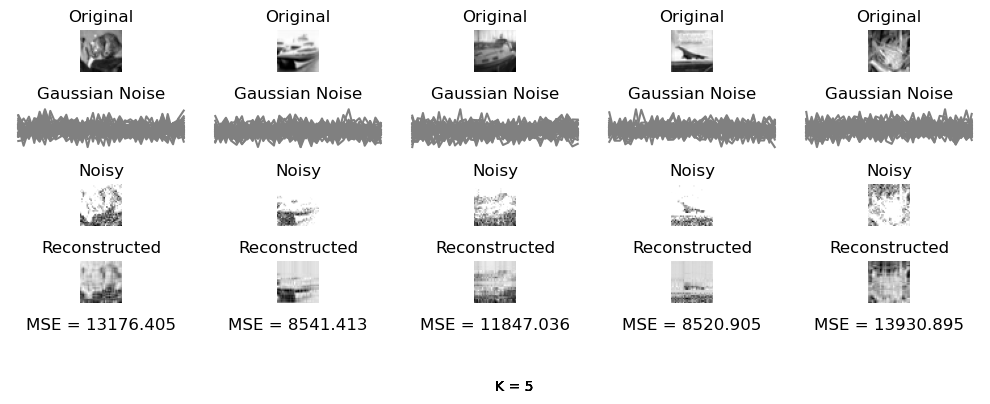

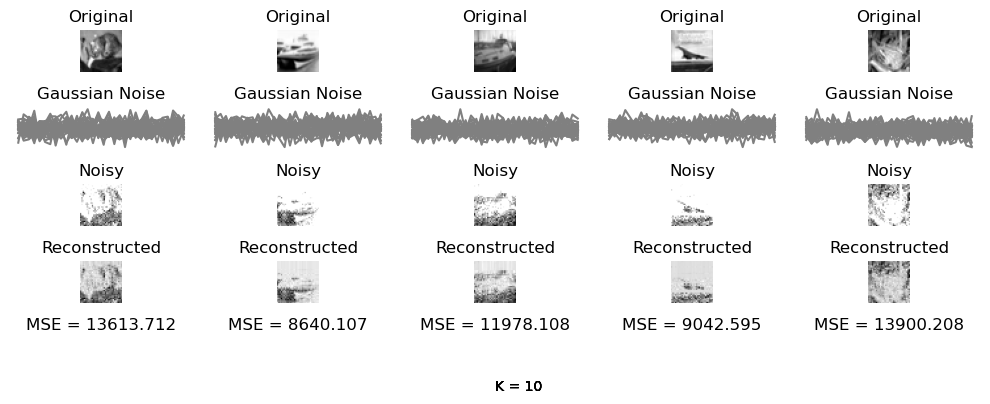

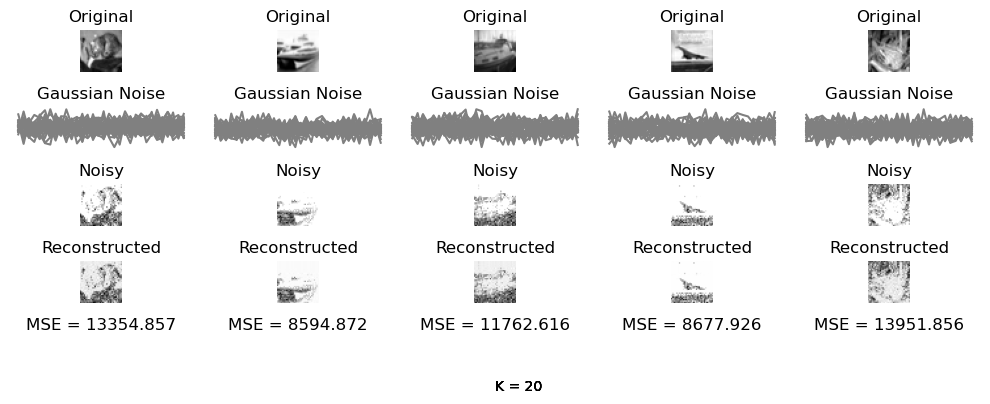

In [93]:
plot_images("cifar", k = 5, mean = 128, sd = 25)
plot_images("cifar", k = 10, mean = 128, sd = 25)
plot_images("cifar", k = 20, mean = 128, sd = 25)

In [ ]:
def image_denoising(dataset, n_images):
    img_n = []
    cr = []
    psnr_iq = []
    mse_result = []
    ssim_result = []
    k_val = []
    result_df = pd.DataFrame()
    psnr_avg = []
    mse_avg = []
    ssim_avg = []

    for k in range(5, 120, 5):
        for i in range(n_images):
            if(dataset == 'cifar'):
                original_image = cifar_x_test[i, :, :, 0]
            if(dataset == 'mnist'):
                original_image = mnist_x_test[i]
            noisy_image, noise = add_gaussian_noise(original_image, 0, 25)
            U, S, Vt = apply_svd(noisy_image)
            U_k, S_k, Vt_k = truncate_svd(U, S, Vt, k)
            compressed_image = reconstruct_image(U_k, S_k, Vt_k)
            compression_ratio, quality, mse, ssim = evaluate_compression(original_image, compressed_image, k)

            psnr_iq.append(quality)
            mse_result.append(mse)
            ssim_result.append(ssim)
            cr.append(compression_ratio)
            img_n.append(i)
            
        psnr_mean = np.mean(psnr_iq)
        mse_mean = np.mean(mse_result)
        ssim_mean = np.mean(ssim_result)
        k_val.append(k)
        psnr_avg.append(psnr_mean)
        mse_avg.append(mse_mean)
        ssim_avg.append(ssim_mean)
    k_df = pd.DataFrame({'K': k_val})
    psnr_df = pd.DataFrame({'PSNR_avg': psnr_avg})
    mse_df = pd.DataFrame({'MSE_avg': mse_avg})
    ssim_df = pd.DataFrame({'SSIM_avg': ssim_avg})

    df = pd.concat([k_df, psnr_df, mse_df, ssim_df], axis = 1)
    result_df = pd.concat([df], axis = 0)
    
    return result_df

In [55]:
mnist_stats = image_denoising('mnist', 100)
cifar_stats = image_denoising('cifar', 100)

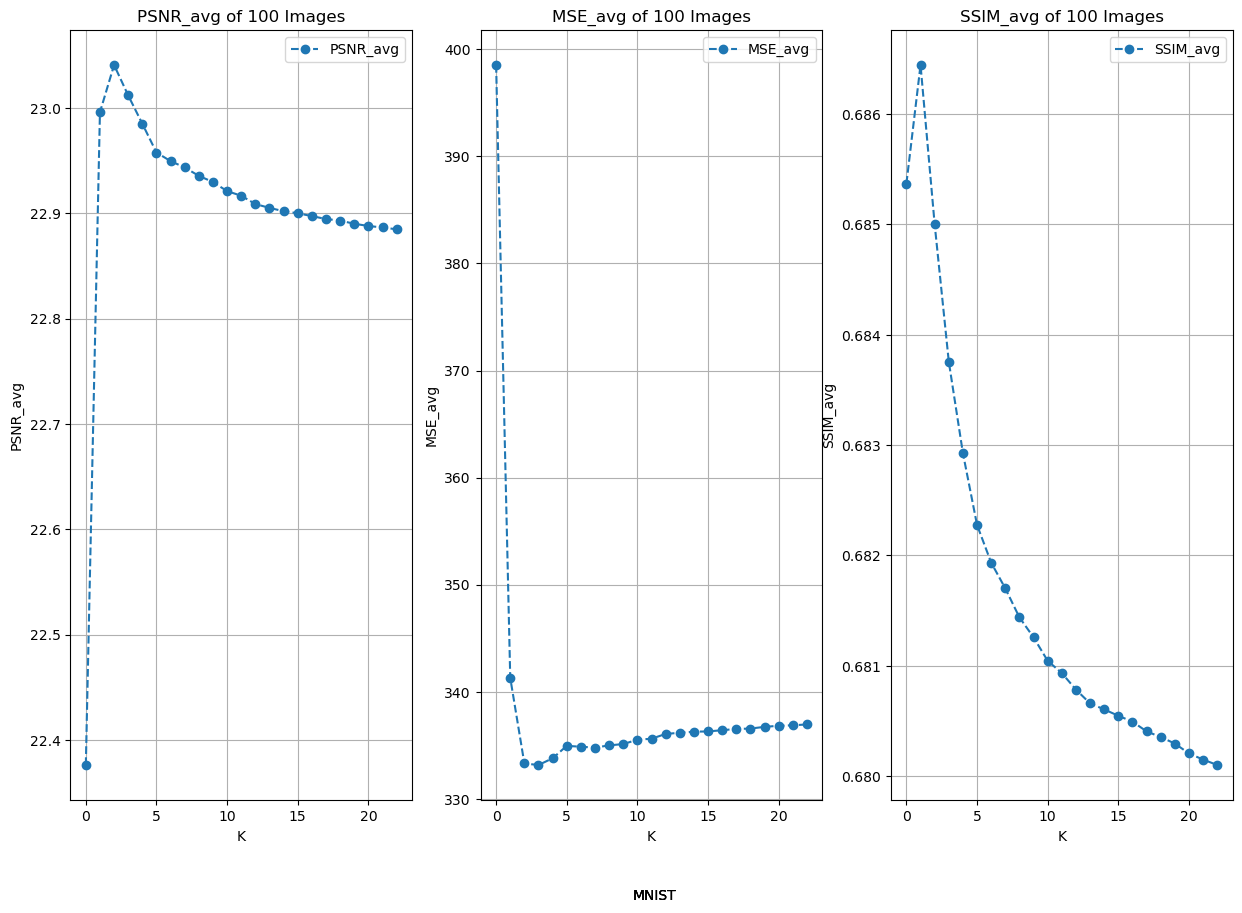

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

colnames = mnist_stats.columns[1:4].tolist()

for i, (col, ax) in enumerate(zip(colnames, axes)):
    ax.plot(mnist_stats[col], label=col, marker='o', linestyle='--')
    ax.set_title(f"{col} of 100 Images")
    ax.set_xlabel("K")
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True)
    plt.figtext(0.5, 0.01, 'MNIST')


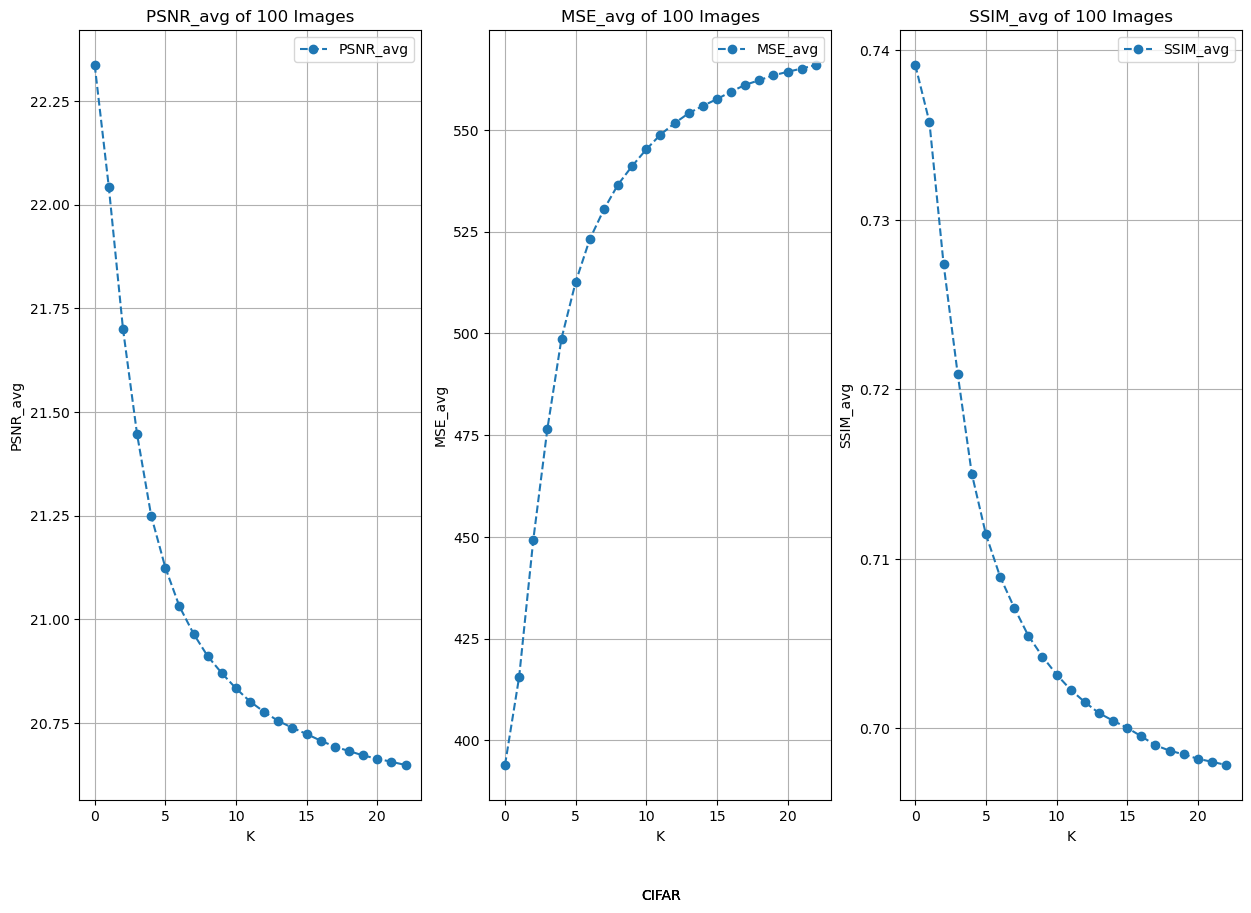

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

colnames = cifar_stats.columns[1:4].tolist()

for i, (col, ax) in enumerate(zip(colnames, axes)):
    ax.plot(cifar_stats[col], label=col, marker='o', linestyle='--')
    ax.set_title(f"{col} of 100 Images")
    ax.set_xlabel("K")
    ax.set_ylabel(col)
    ax.legend()
    ax.grid(True)
    plt.figtext(0.5, 0.01, 'CIFAR')